In [1]:
import numpy as np
from scipy.stats import t as student_t
import seaborn as sns
import matplotlib.pyplot as plt

In [156]:
def get_m_v(Y, C_pre, Psi_pre_inv, X1, X2, tau, sample = 'sample'):

    n = Y.shape[0]
    


    gamma = np.zeros(n) # point estimate of gamma

    if X1 is not None:
        r1 = X1.shape[1]
        A = C_pre[:,:r1]
        B = C_pre[:,r1:]
    else:
        B = C_pre


    v = np.abs(1+(tau[:,np.newaxis]*X2*np.dot(X2, np.dot(B.T, Psi_pre_inv).dot(B))).sum(1)) ** (-1)

    if X1 is not None:
        errors = Y - np.dot(X1,A.T)
    else:
        errors = Y.copy()

    m =  v*(errors*np.dot(tau[:,np.newaxis]*X2, B.T).dot(Psi_pre_inv)).sum(1)

    if sample == 'sample':
        gamma = np.random.normal(loc = m, scale = v**0.5)
    else:
        gamma = m


    return m, v, gamma


def get_tau(Y, X1,X2, gamma, C_pre, Psi_est_inv, nu, sample = 'sample'):

    n = Y.shape[0]
    d = Y.shape[1]
    

    if X1 is not None:
        r1 = X1.shape[1]
        A = C_pre[:,:r1]
        B = C_pre[:,r1:]
    else:
        B = C_pre

    alpha_1 = float((nu+d)/2.0)
    if X1 is not None:
        tmp = Y - np.dot(X1, A.T) - gamma[:, np.newaxis]*np.dot(X2, B.T)
    else:
        tmp = Y - gamma[:, np.newaxis]*np.dot(X2, B.T)

    beta = (nu + (tmp * np.dot(tmp, Psi_est_inv)).sum(1))/2.0
    tau_mean = alpha_1/beta

    if sample == 'sample':
        tau = np.random.gamma(shape = alpha_1, scale = 1/beta)
    elif sample == 'mode':
        tau = (alpha_1-1)/beta
    elif sample == 'mean':
        tau = tau_mean


    return np.abs(tau_mean), np.abs(tau)



def solve_B_psi( X_tilde, Y_tilde, n):


    # M-step
    try:
        C = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.inv(np.dot(X_tilde.T,X_tilde)))
    except:
        C = np.dot(Y_tilde.T, X_tilde).dot(np.linalg.pinv(np.dot(X_tilde.T,X_tilde)))

    Psi_est = np.dot((Y_tilde-np.dot(X_tilde,C.T)).T, (Y_tilde-np.dot(X_tilde,C.T)))/n
    try:
        Psi_est_inv = np.linalg.inv(Psi_est)
    except:
        Psi_est_inv = np.linalg.pinv(Psi_est)


    return C, Psi_est, Psi_est_inv



def get_X_tilde( X1, X2, m,v, tau):
        
        n = X2.shape[0]




        tau_mix = np.sqrt(tau[:,np.newaxis])

        s = v[:,np.newaxis] ** 0.5

        if X1 is not None:
            r1 = X1.shape[1]
            X_tilde =  np.vstack((np.hstack((X1*tau_mix, tau_mix*m[:,np.newaxis]*X2)),np.hstack((np.zeros((n, r1)),tau_mix*s*X2))))
        else:
            X_tilde =  np.vstack((tau_mix*m[:,np.newaxis]*X2,tau_mix*s*X2))

        
        return X_tilde
    

def get_X_bar( X1, X2, tau, gamma):

    if X1 is None:
        with_mean = False
    
    tau_mix = np.sqrt(tau[:,np.newaxis])
    
    gamma = gamma[:,np.newaxis]


    if with_mean:
        X_bar =  np.hstack((X1*tau_mix, tau_mix*gamma*X2))
    elif not with_mean:
        X_bar =  tau_mix*gamma*X2

    
    return X_bar
    
def get_Y_bar(Y, tau):
    return np.sqrt(tau[:, np.newaxis])*Y
    

def get_Y_tilde( Y, tau):

    n = Y.shape[0]
    d = Y.shape[1]
    

    tau_mix = np.sqrt(tau[:,np.newaxis])

    return  np.vstack((Y*tau_mix, np.zeros((n,d))))

def one_step(Y, X1, X2, A, B, Psi_inv, tau, gamma, nu, sample):
    n = Y.shape[0]


    if A is not None:
        C = np.hstack((A,B))
    else:
        C = B

    m,v, gamma = get_m_v(Y, C, Psi_inv, X1, X2, tau, sample = sample)

    X_tilde = get_X_tilde(X1, X2, m,v, tau)
    Y_tilde = get_Y_tilde(Y, tau)

    C_est, Psi_est, Psi_pre_inv = solve_B_psi(X_tilde, Y_tilde, n)

    #if error is t we have to do another EM step
    tau_mean, tau = get_tau(Y, X1, X2, gamma, C_est, Psi_pre_inv, nu, sample)
    X_bar =  get_X_bar(X1, X2, tau_mean, gamma)
    Y_bar =  get_Y_bar(Y, tau_mean)

    C_est, Psi_est, Psi_pre_inv = solve_B_psi(X_bar, Y_bar, n)

    return C_est, Psi_est, Psi_pre_inv, tau_mean, tau, m,v,gamma


def one_step_wrong(Y, X1, X2, A, B, Psi_inv, tau, gamma, nu, sample):
    n = Y.shape[0]


    if A is not None:
        C = np.hstack((A,B))
    else:
        C = B


    m, v, gamma = get_m_v(Y, C, Psi_inv, X1, X2, tau, sample = sample)


    tau_mean, tau = get_tau(Y,X1, X2, gamma, C, Psi_inv, nu, sample = sample)


    X_tilde = get_X_tilde(X1, X2, m,v, tau_mean)
    Y_tilde = get_Y_tilde(Y, tau_mean)
    C_est, Psi_est, Psi_pre_inv = solve_B_psi(X_tilde, Y_tilde,n)

    return C_est, Psi_est, Psi_pre_inv, tau_mean, tau, m,v,gamma





Simulate data

In [157]:

tol = 1e-6
max_iter = 200
nu = 5
rnd = np.random.RandomState(42)

n = 1000
r = 5
d = 3

X = rnd.normal(loc = 0, scale = 1, size = (n,r))


# Generate coef matrix
B_true = rnd.normal(loc = 0, scale = 1, size = (d,r))
B_true[np.abs(B_true)<0.7] = 0


# Generate observations

st_dist = student_t(df = nu, scale = 1)
st_dist.random_state = np.random.RandomState(5)


gamma = rnd.normal(loc = 0, scale = 1, size = (n))
epsilon = st_dist.rvs(size = (n, d))

Y_cov = gamma[:, np.newaxis]*np.dot(X, B_true.T) + epsilon





In [166]:
def plot_things(tau_1, tau_2, m_1, m_2, v_1, v_2, tau_mean_1, tau_mean_2):
    fig, ax = plt.subplots(2,2, figsize = (10,7))
    sns.kdeplot(tau_1, ax = ax[0,0], label = "correct")
    sns.kdeplot(tau_2, ax = ax[0,0], label = "wrong")
    ax[0,0].set_title("tau mode")
    ax[0,0].legend()

    sns.kdeplot(m_1, ax = ax[0,1], label = "correct")
    sns.kdeplot(m_2, ax = ax[0,1], label = "wrong")
    ax[0,1].set_title("m")
    ax[0,1].legend()


    sns.kdeplot(v_1, ax = ax[1,0], label = "correct")
    sns.kdeplot(v_2, ax = ax[1,0], label = "wrong")
    ax[1,0].set_title("v")
    ax[1,0].legend()


    sns.kdeplot(tau_mean_1, ax = ax[1,1], label = "correct")
    sns.kdeplot(tau_mean_2, ax = ax[1,1], label = "wrong")
    ax[1,1].set_title("tau mean")
    ax[1,1].legend()



    fig, ax = plt.subplots(2,2, figsize = (10,7))
    ax[0,0].plot(tau_1, label = "correct")
    ax[0,0].plot(tau_2, label = "wrong")
    ax[0,0].set_title("tau mode")
    ax[0,0].legend()

    ax[0,1].plot(m_1, label = "correct")
    ax[0,1].plot(m_2, label = "wrong")
    ax[0,1].set_title("m")
    ax[0,1].legend()

    ax[1,0].plot(v_1, label = "correct")
    ax[1,0].plot(v_2, label = "wrong")
    ax[1,0].set_title("v")
    ax[1,0].legend()

    ax[1,1].plot(tau_mean_1, label = "correct")
    ax[1,1].plot(tau_mean_2, label = "wrong")
    ax[1,1].set_title("tau mean")
    ax[1,1].legend()


In [130]:

B_init = B_true# np.ones((d,r))
psi_init = np.identity(d)*(nu-1)/nu
psi_inv_init = np.linalg.inv(psi_init)
tau_init = np.ones(n)
gamma_init = np.ones(n)


#Y, X1, X2, A, B, Psi_inv, tau, gamma, nu, sample

C_1, Psi_1, Psi_inv_1, tau_mean_1, tau_1, m_1,v_1,gamma_1 = one_step(Y_cov, None, X, None, B_init, psi_inv_init, tau_init, gamma_init, nu, 'mode')
C_2, Psi_2, Psi_inv_2, tau_mean_2, tau_2, m_2,v_2,gamma_2 = one_step_wrong(Y_cov, None, X, None, B_init, psi_inv_init, tau_init, gamma_init, nu, None)



print(np.round(C_1,2))
print(np.round(C_2,2))


[[-0.   -0.02 -1.91  0.04  0.86]
 [-1.35  1.13  0.02 -0.79 -0.03]
 [ 1.72  0.79 -0.03  0.01  0.03]]
[[ 0.   -0.02 -1.78  0.04  0.78]
 [-1.28  1.04  0.01 -0.75 -0.01]
 [ 1.6   0.73 -0.03  0.03  0.02]]


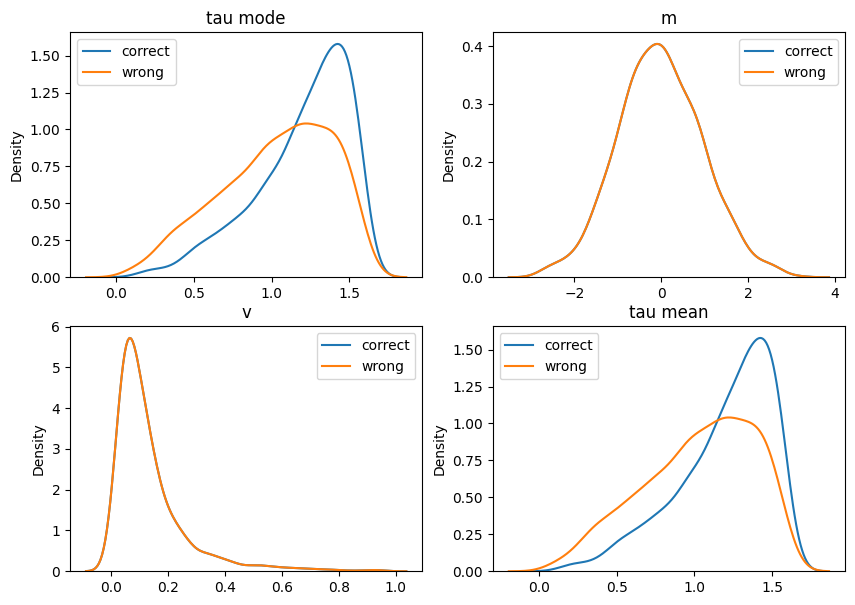

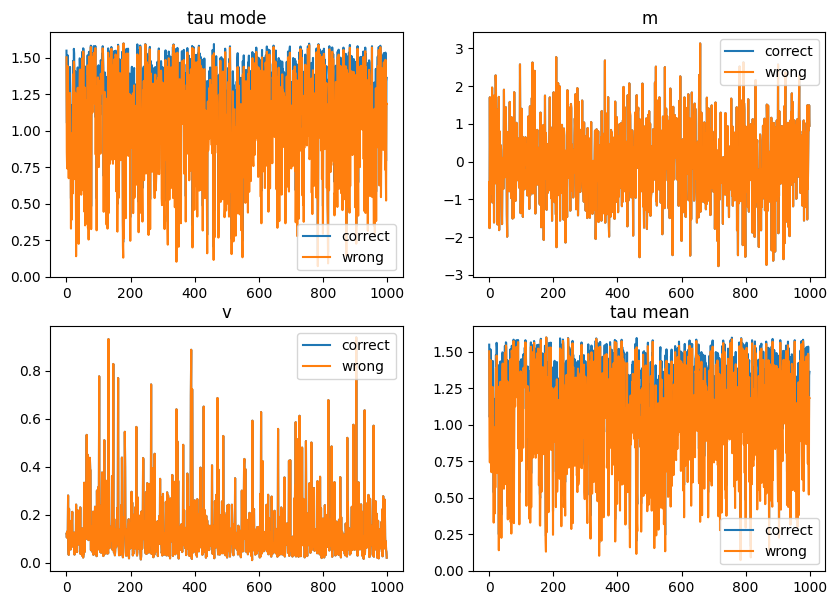

In [170]:
idx = 1
plot_things(tau_1[idx], tau_2[idx], m_1[idx], m_2[idx], v_1[idx], v_2[idx], tau_mean_1[idx], tau_mean_2[idx])

In [164]:
nr_itr = 100


B_init = B_true# np.ones((d,r))
psi_init = np.identity(d)*(nu-1)/nu
psi_inv_init = np.linalg.inv(psi_init)
tau_init = np.ones(n)*1
gamma_init = np.ones(n)*10

C_1 = np.zeros((nr_itr+1, d,r))
C_1[0] = B_init.copy()
psi_1 = np.zeros((nr_itr+1, d,d))
psi_1[0] = psi_init.copy()
psi_inv_1 = np.zeros((nr_itr+1, d,d))
psi_inv_1[0] = psi_inv_init.copy()
tau_1 = np.zeros((nr_itr+1, n))
tau_1[0] = tau_init.copy()
gamma_1 = np.zeros((nr_itr+1, n))
gamma_1[0] = gamma_init.copy()
tau_mean_1 = np.zeros((nr_itr+1, n))
m_1 = np.zeros((nr_itr+1, n))
v_1 = np.zeros((nr_itr+1, n))


C_2 = np.zeros((nr_itr+1, d,r))
C_2[0] = B_init.copy()
psi_2 = np.zeros((nr_itr+1,d,d))
psi_2[0] = psi_init.copy()
psi_inv_2 = np.zeros((nr_itr+1, d,d))
psi_inv_2[0] = psi_inv_init.copy()
tau_2 = np.zeros((nr_itr+1, n))
tau_2[0] = tau_init.copy()
gamma_2 = np.zeros((nr_itr+1, n))
gamma_2[0] = gamma_init.copy()
tau_mean_2 = np.zeros((nr_itr+1, n))
m_2 = np.zeros((nr_itr+1, n))
v_2 = np.zeros((nr_itr+1, n))

#Y, X1, X2, A, B, Psi_inv, tau, gamma, nu, sample

for i in range(nr_itr):
    C_1[i+1], psi_1[i+1], psi_inv_1[i+1], tau_mean_1[i+1], tau_1[i+1], m_1[i+1],v_1[i+1], gamma_1[i+1] = one_step(Y_cov, None, X, None, C_1[i], psi_inv_1[i], tau_1[i], gamma_1[i], nu, 'mean')
    C_2[i+1], psi_2[i+1], psi_inv_2[i+1], tau_mean_2[i+1], tau_2[i+1], m_2[i+1],v_2[i+1], gamma_2[i+1] = one_step_wrong(Y_cov, None, X, None, C_2[i], psi_inv_2[i], tau_2[i], gamma_2[i], nu, 'mean')



In [165]:
print(tau_1[-1][:5])
print(tau_mean_1[-1][:5])

[1.50528261 1.14735775 0.85391514 0.87761516 1.51282631]
[1.50528261 1.14735775 0.85391514 0.87761516 1.51282631]


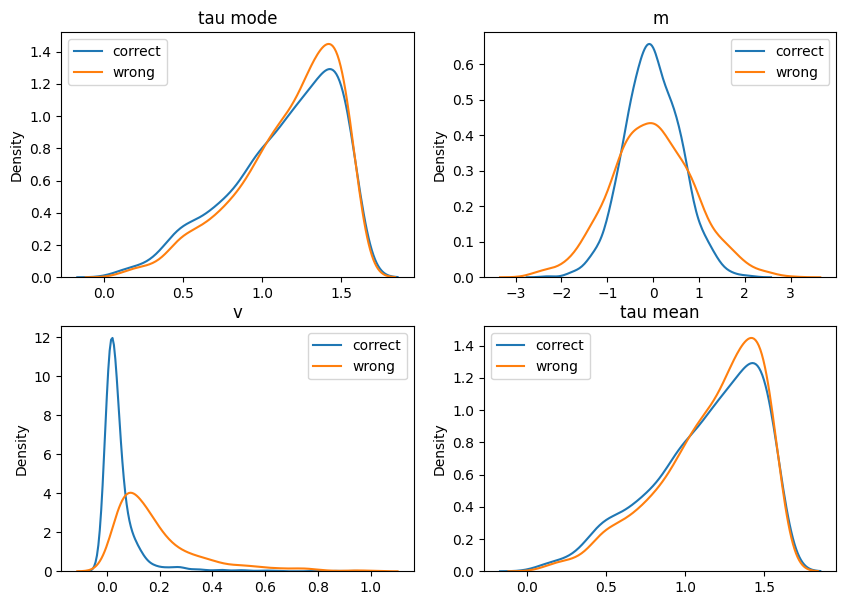

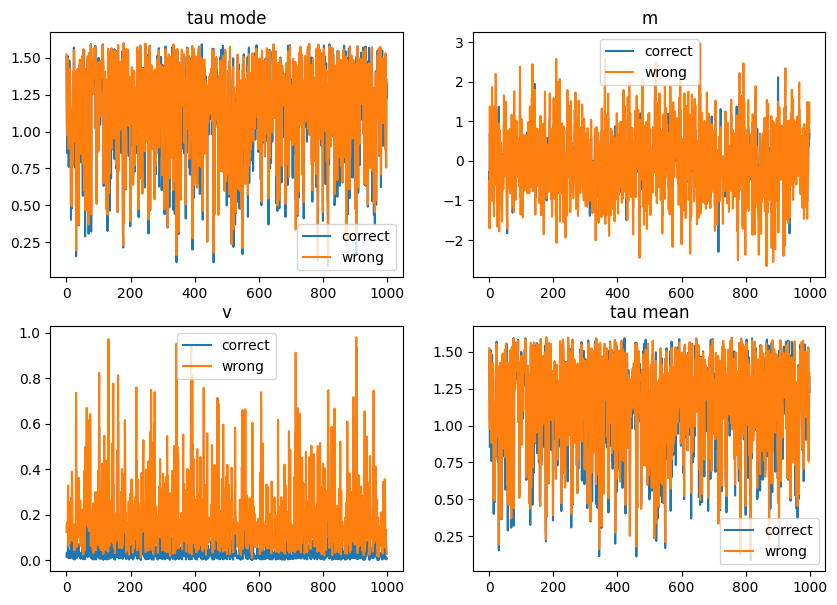

In [155]:
plot_things()

In [153]:
print(np.round(B_true,2))
print("")
print(np.round(C_1,2))
print("")
print(np.round(C_2,2))
print("Error correct:")
print(np.linalg.norm(B_true-C_1))
print("Error wrong:")
print(np.linalg.norm(B_true-C_2))

[[ 0.    0.   -1.8   0.    0.73]
 [-1.27  1.05  0.   -0.73  0.  ]
 [ 1.6   0.73  0.    0.    0.  ]]

[[ 0.01 -0.04 -2.26  0.1   1.11]
 [-1.69  1.32  0.06 -0.98 -0.06]
 [ 2.13  0.92 -0.09  0.08  0.04]]

[[ 0.   -0.03 -1.76  0.07  0.85]
 [-1.29  1.03  0.02 -0.78 -0.03]
 [ 1.61  0.72 -0.05  0.07  0.03]]
Error correct:
1.0114240910253363
Error wrong:
0.1819774487105409


In [24]:
print(n)

[[nan nan nan nan nan]
 [nan nan nan nan nan]
 [nan nan nan nan nan]]
